In [599]:
using CSV
using DataFrames
using Distributions
using GLM
using LaTeXStrings
using LinearAlgebra
using Measurements
using MLJ
# using MLJGLMInterface # For using GLM models with the MLJ.mach interface etc.
using MLJLinearModels
using Statistics
using StatsBase
using StatsPlots
theme(:default)

"Round everything in a vector"
function Base.round(v)
    map(x -> round(x, digits=3), v)
end;

"Projection matrix for ordinary least squares with uncorrelated errors.
This is used for finding standardised residuals, but we probably want a 
better way because the numerical stability of this is poor." 
function hat(x)
    x = hcat(repeat([1], size(x)[1]), x)
    x * inv(x' * x) * x'
end;

# Week 1

## 1.3 Town And Country
A small example of parameter estimation.
Unable to produce the results relating to sum of squared residuals in
https://edstem.org/au/courses/14249/lessons/45444/slides/309282
exactly.

In [600]:
town = [0,1,1,0,2,3,0,1,1,1,1,2,0,1,3,0,1,2,1,3,3,4,1,3,2,0]
country = [2,0,3,0,0,1,1,1,1,0,0,2,2,0,1,2,0,0,1,1,1,0,2]

"log likelihood of θ given y, Poisson distribution."
function l(θ, y) 
    sum(map(yi -> yi * log(θ) - θ - log(factorial(yi)), y))
end

# Under H0, calculate the log likelihood of the MLE given the observed data.
town_and_country  = vcat(town, country)
θ0_mle            = mean(town_and_country)
l0                = l(θ0_mle, town_and_country)

# Under H1 the two groups have different rate parameters.
θ1_town_mle       = mean(town)
θ1_country_mle    = mean(country)
l1                = l(θ1_town_mle, town) + l(θ1_country_mle, country)
print("I have no idea if the difference between $(round(l0, digits=3)) and $(round(l1, digits=3)) (the likelihoods under H0 and H1) is significant.")

I have no idea if the difference between -68.387 and -67.023 (the likelihoods under H0 and H1) is significant.

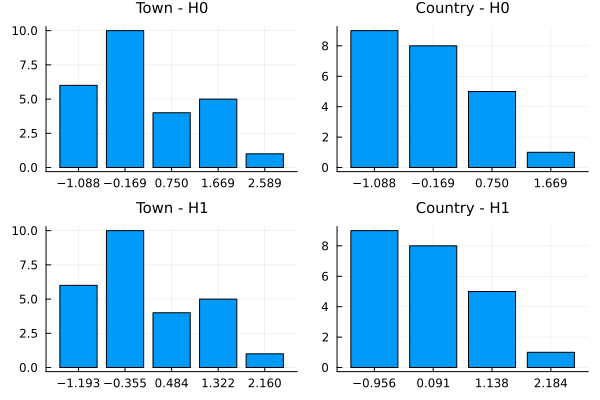

In [601]:
function res(sample, mle)
    (sample .- mle) ./ sqrt(mle)
end

# Residuals for each group.
function resplot(sample, mle, title="")
    r = res(sample, mle)
    xticks = r |> countmap |> keys |> collect |> sort |> round
    bar(countmap(r), xticks=xticks, label="", title=title)
end

# These are supposed to look like Gaussians but I wouldn't say they do, or that H0 and H1 look meaningfully different.
plot(
    resplot(town, θ0_mle, "Town - H0"),
    resplot(country, θ0_mle, "Country - H0"),
    resplot(town, θ1_town_mle, "Town - H1"),
    resplot(country, θ1_country_mle, "Country - H1"),
    titlefont=(10)
    )

In [602]:
# Sum of squared residuals under H0 and H1
sse_0 = sum(res(town_and_country, θ0_mle).^2)
sse_1 = sum(res(town, θ1_town_mle).^2) + sum(res(country, θ1_country_mle).^2)

# Unable to reproduce data from the slides.
(sse_0, sse_1, sse_0 - sse_1) |> round

(46.759, 43.659, 3.1)

## 1.4 Estimation Procedure
In this section a Weibull distribution is fitted to a dataset of times to fail for 'Kevlar epoxy strand pressure vessels'.

In [603]:
# Records of time to failure.
ttf = [1051, 1337, 1389, 1921, 1942, 2322, 3629, 
    4006, 4012, 4063, 4921, 5445, 5620, 
    5817, 5905, 5956, 6068, 6121, 6473, 
    7501, 7886, 8108, 8546, 8666, 8831, 
    9106, 9711, 9806, 10205, 10396, 10861, 
    11026, 11214, 11362, 11604,11608, 11745, 
    11762, 11895, 12044, 13520, 13670, 14110, 
    14496, 15395, 16179, 17092, 17568, 17568];

In [604]:
"MLE of the scale parameter given the shape parameter, Weibull distribution."
function θ_mle(y, λ)
    (sum(y .^ λ) / length(y)) ^ (1 / λ)
end;
round(θ_mle(ttf, 2), digits=2)

9892.18

In [605]:
"Newtown's Method to solve f(x) = 0 given an initial guess.
f  - a R to R function
df - its derivative
x0 - initial guess"
function newtown(x0, f, df, tolerance = 1e-5)
    x1 = missing # Insantiate outside the while block.
    while true
        x1 = x0 - f(x0) / df(x0)
        abs(x0 - x1) < tolerance && break
        x0 = x1
    end
    x1
end    

"Derivative of Weibull log-likelihood wrt θ."
function score(θ, y, λ)
    - (length(y)) * λ / θ + sum((λ .* (y .^ λ))) / (θ ^ (λ + 1))
end;

function d_score(θ, y, λ)
    (length(y)) * λ / (θ ^ 2) - sum((λ .* (y .^ λ))) * (λ + 1) / (θ ^ (λ + 2))
end;

round(newtown(mean(ttf), θ -> score(θ, ttf, 2), θ -> d_score(θ, ttf, 2)), digits=2)

9892.18

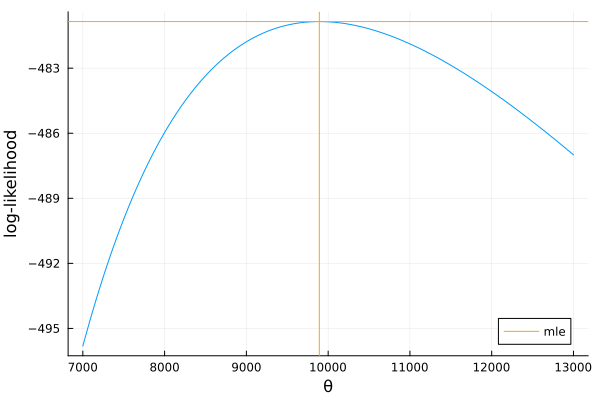

In [606]:
x = LinRange(7000, 13000, 300)
function loglikelihood(θ, y, λ)
    N = length(y)
    N * (log(λ) - λ * log(θ)) + (λ - 1) * sum(log.(y)) - sum(y .^ λ) / (θ ^ λ)
end
y = map(t -> loglikelihood(t, ttf, 2), x)
plot(x, y, label="", xlabel="θ", ylabel="log-likelihood")
vline!([θ_mle(ttf, 2)], label="mle", color="orange")
hline!([loglikelihood(θ_mle(ttf, 2), ttf, 2)], label="", color="orange")

# Week 2: Linear Models

## 2.1 Simple Linear Models

In [607]:
using MLDatasets: BostonHousing
df = BostonHousing()

dataset BostonHousing:
  metadata   =>    Dict{String, Any} with 5 entries
  features   =>    506×13 DataFrame
  targets    =>    506×1 DataFrame
  dataframe  =>    506×14 DataFrame

In [ ]:
plot(
    boxplot(df.features.LSTAT, xlabel="LSTAT", label=""), 
    boxplot(df.targets.MEDV,   xlabel="MEDV",  label=""),
    scatter(
    df.features.LSTAT, 
    df.targets.MEDV, 
    label="", 
    xlabel="% Of Households with Low Socioeconomic Status", 
    ylabel="Median House Value",
    alpha=.3)
)
# We might have some outliers.

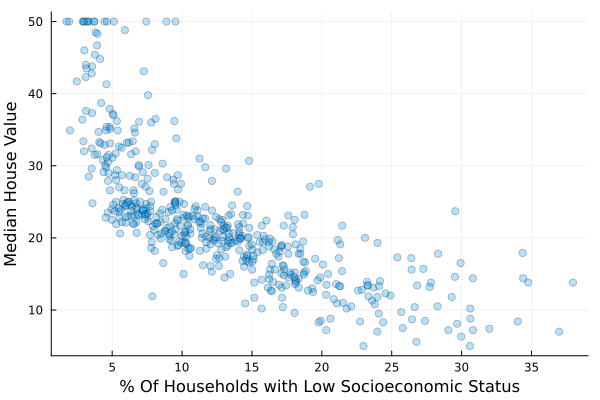

In [609]:
# Simple example with one explanatory variable.
scatter(
    df.features.LSTAT, 
    df.targets.MEDV, 
    label="", 
    xlabel="% Of Households with Low Socioeconomic Status", 
    ylabel="Median House Value",
    alpha=.3)

In [610]:
x  = Matrix(df.features[:, [:LSTAT]])
y  = df.targets.MEDV
m  = lm(hcat(repeat([1], length(x)), x), y)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────
        Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────
x1  34.5538     0.562627    61.42    <1e-99   33.4485   35.6592
x2  -0.950049   0.0387334  -24.53    <1e-87   -1.02615  -0.873951
─────────────────────────────────────────────────────────────────


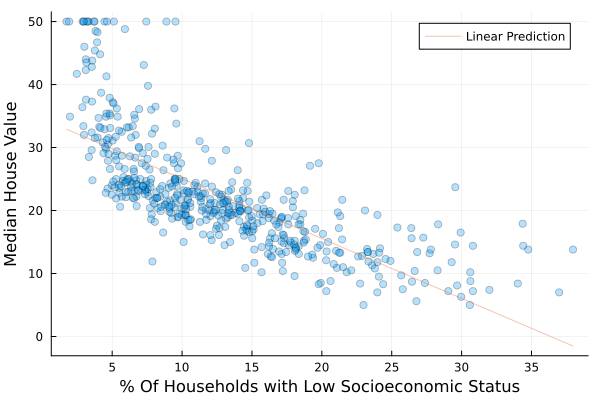

In [611]:
plot!(x, StatsBase.predict(m), label="Linear Prediction", alpha=.4)

In [612]:
# Coefficients of the linear model.
coef(m)

2-element Vector{Float64}:
 34.55384087938303
 -0.9500493537579858

In [613]:
y_pred = GLM.predict(m)
n      = length(y)
ϵ      = y - y_pred
rss    = ϵ' * ϵ
tss    = sum((y .- mean(y)).^2)
σ_hat  = sqrt(rss / (n - 2)) # Residual standard error
xbar   = mean(x)
r2     = (tss - rss) / tss
α      = .05

# Standard error for model parameters.
se_intercept = σ_hat * sqrt(1/n + xbar^2 / sum((x .- xbar).^2))
se_slope     = σ_hat / sqrt(sum((x .- xbar).^2))

# Confidence Intervals for model params.
ci_intercept = ([-1, 1] .* quantile(TDist(n-2), 1 - α/2) * se_intercept) .+ coef(m)[1]
ci_slope     = ([-1, 1] .* quantile(TDist(n-2), 1 - α/2) * se_slope) .+ coef(m)[2]

# Compare home made and library stats.
print("Residuals:                  $(ϵ[1:4] |> round)...\n")
print("With GLM:                   $(GLM.residuals(m)[1:4] |> round)...\n\n")

print("R2:                         $(round(r2, digits=3))\n")
print("With GLM:                   $(round(GLM.r2(m), digits=3))\n\n")

print("Std Err of Coefs:           $([se_intercept, se_slope] |> round)\n")
print("With GLM:                   $(GLM.stderror(m) |> round)\n\n")

print("CI for slope parameter:     $(ci_slope |> round)\n")
print("With GLM:                   $(GLM.confint(m)[2, [1, 2]] |> round)\n\n")

print("CI for intercept parameter: $(ci_intercept |> round)\n")
print("With GLM:                   $(GLM.confint(m)[1, [1, 2]] |> round)\n\n")

Residuals:                  [-5.823, -4.27, 3.975, 1.639]...
With GLM:                   [-5.823, -4.27, 3.975, 1.639]...

R2:                         0.544
With GLM:                   0.544

Std Err of Coefs:           [0.563, 0.039]
With GLM:                   [0.563, 0.039]

CI for slope parameter:     [-1.026, -0.874]
With GLM:                   [-1.026, -0.874]

CI for intercept parameter: [33.448, 35.659]
With GLM:                   [33.448, 35.659]



In [614]:
slope_low, slope_high = ci_slope;
xx   = LinRange(minimum(x), maximum(x), 200)
low  = coef(m)[1] .+ slope_low .* xx;
high = coef(m)[1] .+ slope_high .* xx;

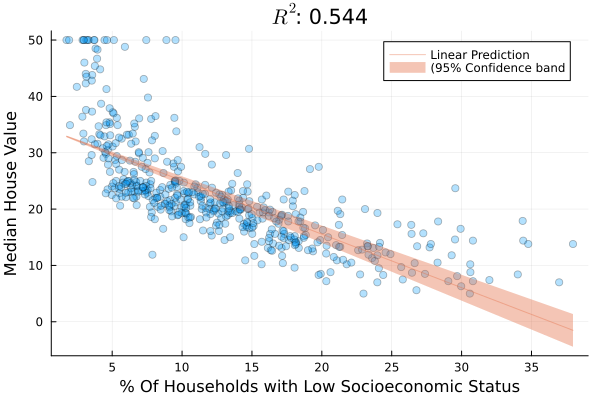

In [615]:
plot!(xx, low, fillrange=high, fillalpha = 0.4, c = 2, label = "(95% Confidence band", w=0)
# Note that the r2 is pretty bad.
plot!(title=L"R^2" * ": $(round(r2, digits=3))")
# Also note that the confidence interval stuff is meaningles since the relationship is obviously non-linear.

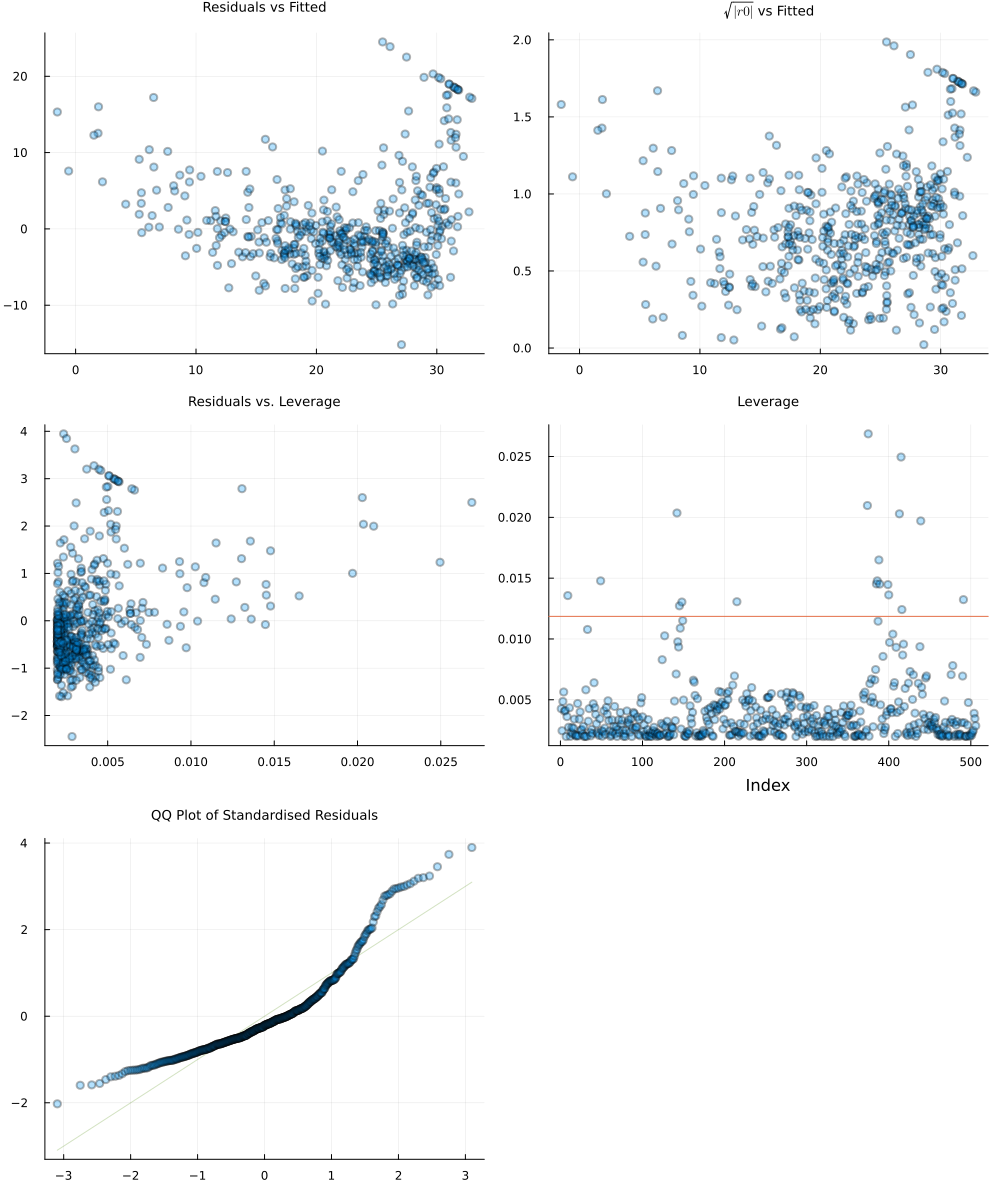

In [616]:
h        = hat(x)
leverage = diag(h)
r0       = ϵ ./ (σ_hat .* sqrt.(1 .- diag(h))) # Standardised residuals

p0 = scatter(y_pred, ϵ, alpha=.3, title="Residuals vs Fitted", label="")
p1 = scatter(y_pred, sqrt.(abs.(r0)), alpha=.3, title = L"\sqrt{|r0|}" * " vs Fitted", label = "")
p2 = scatter(leverage, r0, alpha=.3, title="Residuals vs. Leverage", label="");
p3 = scatter(leverage, alpha=.3, label="", title="Leverage", xlabel="Index")
hline!([3 * 2/n], label="");
p4 = qqnorm(r0, alpha=.3, title="QQ Plot of Standardised Residuals");
plot(p0, p1, p2, p3, p4, titlefont=(9), size=(1000, 1200) ,layout=(3, 2))

## 2.2 Linear Models (LM): estimations, residuals and assessing model assumptions
In this example a Gaussian GLM is fit to a small dataset.
R is happy to compute Cook's Distance for such models but the GLM library in Julia 
seems to only want to do it for OLS linear models.

In [637]:
df = DataFrame(CSV.File("data/mitsub.txt"))
m = glm(@formula(price ~ age), df, Normal(), IdentityLink());

In [638]:
y_pred = GLM.predict(m)
n      = length(y_pred)
ϵ      = df.price - y_pred
sse    = ϵ' * ϵ
σ_hat  = sqrt(1 / (n - 2) * sse);

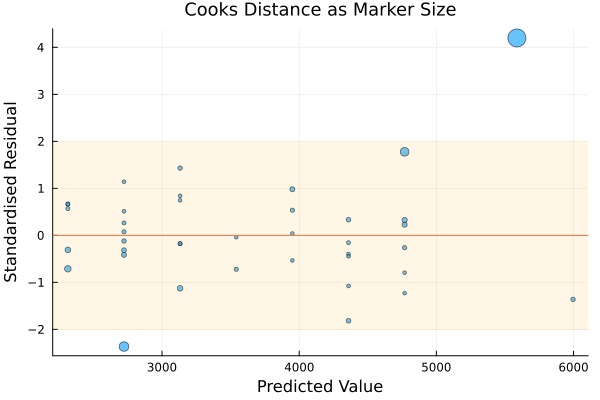

In [649]:
h  = hat(df.price)
r0 = ϵ ./ (σ_hat .* sqrt.(1 .- diag(h))) # Standardised residuals

lev   = diag(h) # leverage
cooks =  (lev ./ (1 .- lev)) 
cooks = cooks / maximum(cooks) # Normalise

p1 = scatter(
    y_pred, 
    r0, 
    label="", 
    ylabel="Standardised Residual",
    xlabel="Predicted Value",
    title="Cooks Distance as Marker Size", 
    alpha=.6, 
    markersize = 10 * cooks.^.5, #exaggerate,
    titlefont=12
    )
hline!([0], label=""); hline!([-2], fillrange=2, alpha=.1, color="orange", label="")

## 2.2 Basketball
Example fitting a multiple linear model.

In [620]:
df = DataFrame(CSV.File("data/basketball.txt"))
display(first(df, 5))

5×6 DataFrame
 Row │ PPM      APM      Height  MPG      Age    Name       
     │ Float64  Float64  Int64   Float64  Int64  String15   
─────┼──────────────────────────────────────────────────────
   1 │  0.5885   0.0888     201    36.02     28  R.Miller
   2 │  0.8291   0.1399     198    39.32     30  M.Jordan
   3 │  0.4974   0.0747     198    38.8      26  D.West
   4 │  0.5772   0.0983     191    40.71     30  J.Dumars
   5 │  0.5703   0.1276     196    38.4      28  M.Richmond

In [621]:
m1 =  lm(@formula(PPM ~ APM + Height + MPG + Age), df);
m2 = glm(@formula(PPM ~ APM + Height + MPG + Age), df, Normal(), IdentityLink());

# There is really no difference between the two models.
print("Largest difference between model predictions:\n")
abs.(StatsBase.predict(m1) - StatsBase.predict(m2)) |> maximum |> print

Largest difference between model predictions:
4.773959005888173e-15

In [622]:
# Format this as a nice regression equation...
zip(coef(m1) |> round, ["Intercept", "APM", "Height", "MPG", "Age"]) |> collect

5-element Vector{Tuple{Float64, String}}:
 (0.221, "Intercept")
 (-0.549, "APM")
 (0.001, "Height")
 (0.008, "MPG")
 (-0.001, "Age")

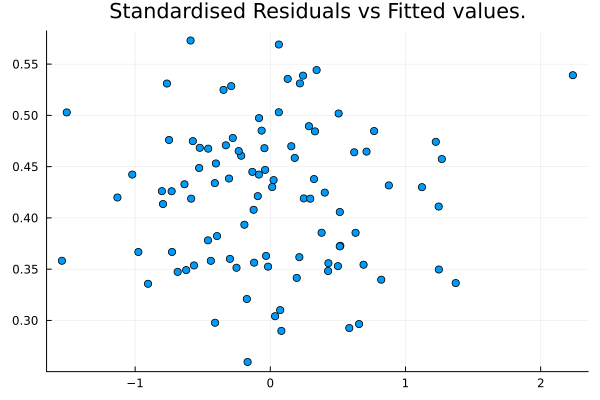

In [623]:
x      = df[:, 2:5]
y      = df.PPM
h      = hat(Matrix(x))
y_pred = StatsBase.predict(m1)
ϵ      = y - y_pred
sse    = ϵ' * ϵ
σ_hat  = sqrt(1 / (n - 2) * sse)
r0     = ϵ ./ (σ_hat .* sqrt.(1 .- diag(h)))
scatter(r0, y_pred, label="", title="Standardised Residuals vs Fitted values.")
# Looks nice and random.

In [624]:
# R2 is bad; need a better model.
round(GLM.r2(m1), digits=2)

0.42

In [625]:
m0 =  lm(@formula(PPM ~ 1), df); # A model for the null hypothesis.
ftest(m0.model, m1.model)
# Assuming that PPM is linearly related to the inputs (which it surely isn't)
# we can be confident that not all coefficients are zero.

# Is this actually right?

F-test: 2 models fitted on 96 observations
────────────────────────────────────────────────────────────────
     DOF  ΔDOF     SSR     ΔSSR      R²     ΔR²       F*   p(>F)
────────────────────────────────────────────────────────────────
[1]    2        1.1259           0.0000                         
[2]    6     4  0.6538  -0.4720  0.4193  0.4193  16.4239  <1e-09
────────────────────────────────────────────────────────────────

## 2.3 Hypothesis Testing, Cheese Data

P: 3.8101846887572677e-6
f: 16.221434265328167

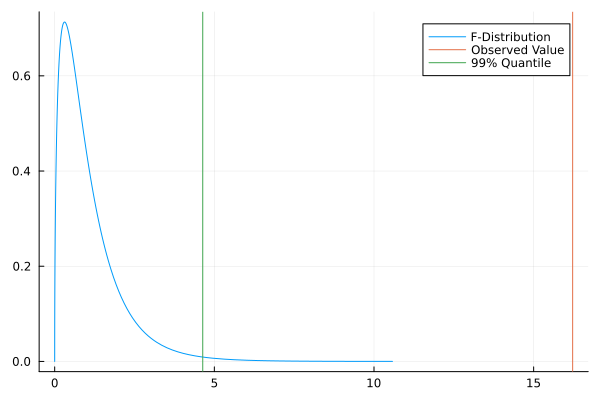

In [626]:
df   = DataFrame(CSV.File("data/cheese.csv"))
m    = lm(@formula(taste ~ acetic + H2S + lactic), df)
r2   = GLM.r2(m)
n    = size(df)[1]
p    = coef(m) |> length

# Calculate the F statistic from the R2 value.
f    = r2 / (1 - r2) * (n - p) / (p - 1)

# For a linear Gaussian model we apparantly have this distributed as folllows.
dist = FDist(p-1, n-p)

# The probability of a value at least as large as that observed under the null: 
print("P: $(1 - cdf(dist, f))\n")
print("f: $f")

plot(dist, label="F-Distribution")
vline!([f], label="Observed Value")
vline!([quantile(dist, 0.99)], label="99% Quantile")

In [627]:
# Calculate the f-statistic again using the deviance and null deviance:
d0 = nulldeviance(m); d1 = deviance(m)
n = length(eachrow(df))
q = 1; p = 4 # Number of parameters for each model.
f = (d0 - d1) * (n - p) / (p - q) / d1
print("f: $f")
# This agrees with the calculation above

f: 16.221434265328163

## Case Study: Market Data
Predict whether an imaginary stock will go up or down today.

In [628]:
df = DataFrame(CSV.File("data/Smarket.csv"))

display(MLJ.schema(df))
# Year is currently interpreted as a Count but the model we will use wants all inputs to be continuous, 
# and the Directoin is currently a string but needs to be a Multiclass label.
coerce!(df, :Year => MLJ.Continuous, :Direction => Multiclass{2});

# - Seperate ins and outs,
# - drop the daily change since we are practicing binary classification
# - drop the uninformative index column
y, x = unpack(df, ==(:Direction))
select!(x, Not([:Today, :Column1]))

# 'Lock and throw away the key' dataset.
x_train, x_test   = partition(x, 0.8, rng=420)
y_train, y_test = partition(y, 0.8, rng=420)
df = Nothing; x  = Nothing; y  = Nothing

first(x_train, 3)

┌───────────┬────────────┬─────────┐
│ names     │ scitypes   │ types   │
├───────────┼────────────┼─────────┤
│ Column1   │ Count      │ Int64   │
│ Year      │ Count      │ Int64   │
│ Lag1      │ Continuous │ Float64 │
│ Lag2      │ Continuous │ Float64 │
│ Lag3      │ Continuous │ Float64 │
│ Lag4      │ Continuous │ Float64 │
│ Lag5      │ Continuous │ Float64 │
│ Volume    │ Continuous │ Float64 │
│ Today     │ Continuous │ Float64 │
│ Direction │ Textual    │ String7 │
└───────────┴────────────┴─────────┘


3×7 DataFrame
 Row │ Year     Lag1     Lag2     Lag3     Lag4     Lag5     Volume  
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────────────────────────
   1 │  2004.0    0.237    0.129    1.24    -0.309    0.205   1.7049
   2 │  2002.0    1.855   -1.679   -1.455    3.75    -0.302   1.0886
   3 │  2004.0   -0.07     0.404    1.3     -0.102    1.637   1.5607

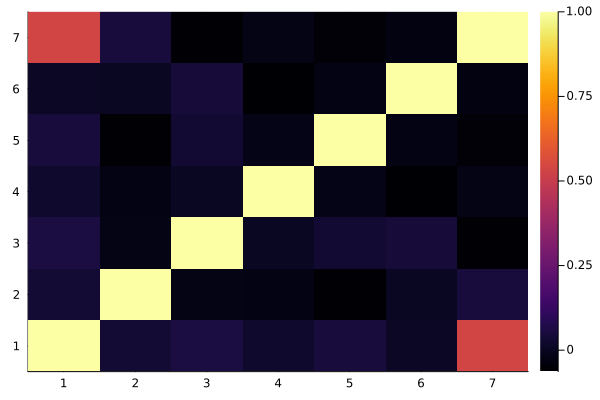

In [629]:
# Pairwise correlations of inputs:
heatmap(x_train |> Matrix |> cor)
# Barely any correlations apart from Year ~ Volume.

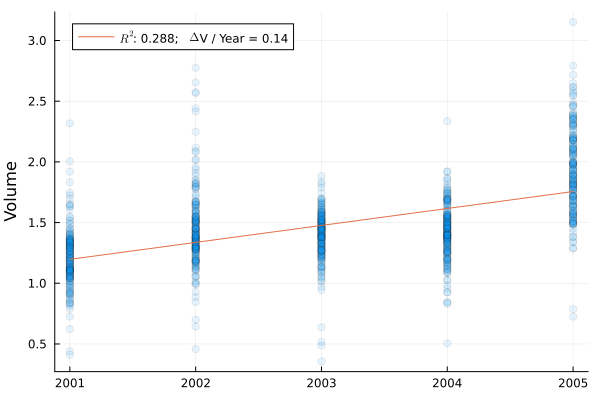

In [630]:
scatter(x_train.Year, x_train.Volume, alpha=0.1, label="", ylabel="Volume")
m = lm(@formula(Volume ~ Year), x_train)
plot!(
    x_train.Year, 
    GLM.predict(m), 
    label = L"R^2" * ": $(round(GLM.r2(m), digits=3));   " * L"\Delta" * "V / Year = $(round(coef(m)[2], digits=3))",
)
# Volume of trades increases yearly.

In [631]:
model = LogisticClassifier(penalty=:none)
# Fit on training data only.
mach = fit!(machine(model, x_train, y_train))
display(confusion_matrix(predict_mode(mach), y_train))
print("\nTraining Accuracy: $(accuracy(predict_mode(mach, x_train), y_train))\n\n")

[ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│ Down │  Up  │
├─────────┼──────┼──────┤
│  Down   │  97  │  84  │
├─────────┼──────┼──────┤
│   Up    │ 384  │ 435  │
└─────────┴──────┴──────┘



Training Accuracy: 0.532



In [632]:
# It appears that we have a model that can predict price changes with better than 50% accuracy :/
# Believable?
print("Test Accuracy: $(accuracy(predict_mode(mach, x_test), y_test))")

Test Accuracy: 0.552

## 2.4 Confidence and Prediction Intervals
Two different ways to describe uncertainty in a predicted value.

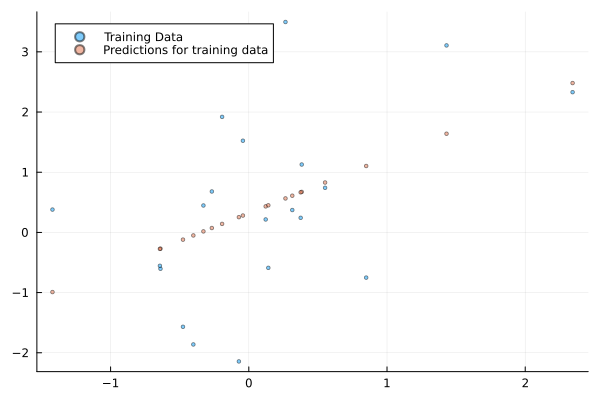

In [633]:
#Simulated data.
n = 20
p = 1
x = rand(Normal(), n)
y = x + rand(Normal(), n)
scatter(x, y, label="Training Data", alpha=.5, markersize=2)

df = DataFrame(hcat(x, y), [:x, :y])
m = lm(@formula(y ~ x), df)
plt = scatter!(x, fitted(m), label="Predictions for training data", alpha=.5, markersize=2)

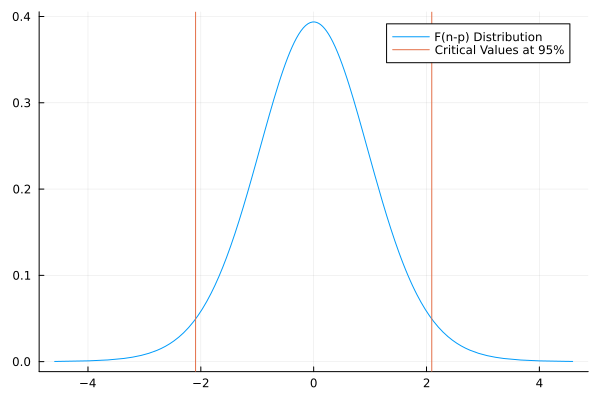

In [634]:
# Just to make sure we know what we're looking at.
dist = TDist(n - p)
plot(dist, label="F(n-p) Distribution")
ci = quantile(dist, [.025, .975])
vline!(ci, label="Critical Values at 95%")

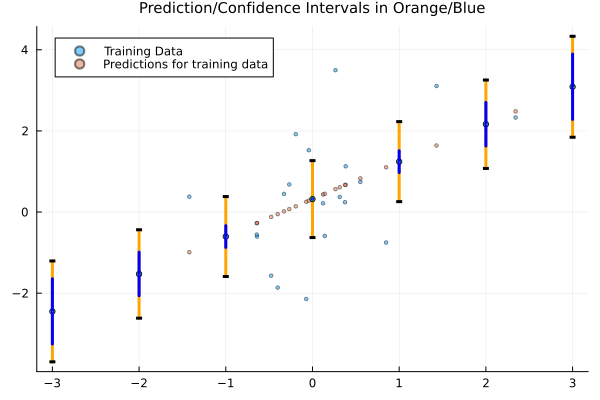

In [635]:
ϵ      = y - fitted(m)
sse    = ϵ' * ϵ
σ_hat  = sqrt(1 / (n - 2) * sse)

"GLM.predict is fussy about input types."
predict_one(x0, m) = GLM.predict(m, DataFrame([[x0]], [:x]))[1]

"Prediction Interval for new data given x and σ_hat."
PI(x0) = predict_one(x0, m) ± quantile(dist, .25) * σ_hat * sqrt(x0' * inv(x' * x) * x0 + 1)

"Confidence interval for new data given x and σ_hat"
CI(x0) = predict_one(x0, m) ± quantile(dist, .25) * σ_hat * sqrt(x0' * inv(x' * x) * x0)

scatter!(plt, -3:3, PI.(-3:3), markersize=3, linecolor=:orange, linewidth=3, label="")
scatter!(plt, -3:3, CI.(-3:3), markersize=0, linecolor=:blue, linewidth=3, label="")
plot!(title = "Prediction/Confidence Intervals in Orange/Blue", titlefont=10)
# Notice that prediction intervals are wider.

In [ ]:
countmap